<a href="https://colab.research.google.com/github/CristylePGarrard/ElectionTime/blob/main/legislative_branch_kpi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
# I want to create a kpi dashboard for candidates that are running again for the same office

# ####### Install necessary libraries ####### #
!pip install gspread gspread-dataframe pandas openpyxl squarify wordcloud

# ####### Import libraries ####### #
import pandas as pd
import gspread
from gspread_dataframe import get_as_dataframe
from google.colab import auth
from googleapiclient.discovery import build
import squarify
import os
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Pull Data

In [2]:
# ################################################### #
# ####### pull in the data for the candidates ####### #
# ################################################### #

# ####### Mount Google Drive to Colab ####### #
from google.colab import drive
drive.mount('/content/drive')

# ####### Set the file path to uploaded Excel file ####### #
# Update the path with the actual location of file in Google Drive
file_path = '/content/drive/My Drive/ut_pol/'
filename = 'cleaned_candidates_data.csv'

# ####### Read the Excel file into a DataFrame ####### #
print("Reading Excel file...")

# There's a weird warning about the format and openpyxl but we don't gotta worry about that so ignore it
import warnings
warnings.simplefilter("ignore")

# Read the Excel file
candidates = pd.read_csv(file_path+filename)

# There are 2 types of candidates running for office in the legislative branch
# Those that have been in office and are running again (incumbent)
# And those who are running to be in office the first time.
# Let's just look at the incumbents and see what legislation they've sponsored and whether it's passed or not passed

# don't need all the info right now
include_columns = ['Name on Ballot', 'First Name', 'Middle Name',
                   'Last Name', 'Office', 'District', 'Party',
                   'Status','Display District', 'record_id', 'Incumbent']
candidates = candidates[include_columns].copy()

# only need candidates that are running again
include_status = ['Election Candidate', 'Write-In']
candidates = candidates.loc[candidates['Status'].isin(include_status)].copy().reset_index(drop=True)

# only look at incumbent candidates
candidates = candidates.loc[candidates['Incumbent'] == True].copy().reset_index(drop=True)
# only look at State House & State Senate
candidates = candidates.loc[candidates['Office'].isin(['State House', 'State Senate'])].copy().reset_index(drop=True)


Mounted at /content/drive
Reading Excel file...


In [3]:
# #################################################################### #
# ####### pull in the data for the bills that have been passed ####### #
# #################################################################### #

bills_file_path = '/content/drive/My Drive/ut_pol/passedBills/'

list_of_bills = os.listdir(bills_file_path)
# print(list_of_bills)

all_data = []

for f in list_of_bills:
  if f.endswith('.csv'):
    temp = pd.read_csv(bills_file_path + f)
    temp['sheet_name'] = f
    all_data.append(temp)

bills = pd.concat(all_data, axis=0, ignore_index=True)

# print(bills.head())

# we only need data for 2021 - 2024
bills['Year'] = bills['sheet_name'].str.extract(r'(\d{4})')
bills = bills.loc[bills['Year'].isin(['2021', '2022', '2023', '2024'])].copy().reset_index(drop=True)

# make sure dtypes are correct
bills['Date Passed'] = pd.to_datetime(bills['Date Passed'], errors='coerce')
bills['Effective Date'] = pd.to_datetime(bills['Effective Date'], errors='coerce')
bills['Gov\'s Action Date'] = pd.to_datetime(bills['Gov\'s Action Date'], errors='coerce')
bills['Year'] = bills['Year'].astype(int)

# What to do when the gov's action is empty

bills['Governor\'s Action'].unique()

bills.loc[bills['Governor\'s Action'].isnull()]

# Replace null values in the 'Governor's Action' column with 'no value'
bills['Governor\'s Action'] = bills['Governor\'s Action'].fillna('NO VALUE').copy().reset_index(drop=True)

# Merge Data

In [4]:
# 1st merge the two dataframes together
# Extracting last name and first initial from Bill Sponsor in the bills dataframe
bills['Last Name'] = bills['Bill Sponsor'].apply(lambda x: x.split(', ')[0])
bills['First Initial'] = bills['Bill Sponsor'].apply(lambda x: x.split(', ')[1][0] if len(x.split(', ')) > 1 else '')

# Create a column to match with candidates by concatenating Last Name and First Initial
bills['Sponsor Key'] = bills['Last Name'] + ' ' + bills['First Initial']

# In the candidates dataframe, create a key column to match with bills
candidates['First Initial'] = candidates['First Name'].str[0]  # Get the first initial
candidates['Candidate Key'] = candidates['Last Name'] + ' ' + candidates['First Initial']

merged_df = pd.merge(candidates, bills, left_on='Candidate Key', right_on='Sponsor Key', how='left')


In [5]:
# Which candidates sponsored no bills?

print(merged_df.loc[merged_df['Bill Number'].isna()]['Name on Ballot'].unique())

['MATT MACPHERSON']


# Create Categories

In [6]:
# Categories targeting keywords in the bills.

categories = {
    'Education': ['higher education',
                  'juvenile',
                  'school',
                  'university',
                  'student',
                  'education',
                  'students',
                  'teacher',
                  'educator',
                  'learning',
                  'academic',
                  'college',
                  'preschool',
                  'daycare',
                  'scholarship',
                  'training',
                  'literacy',
                  'diploma',
                  'certification',
                  'tutoring',
                  'virtual learning',
                  'STEM',
                  'vocational'],
    'Healthcare': ['health',
                   'medical',
                   'hospital',
                   'healthcare',
                   'wellness',
                   'doctor',
                   'nurse',
                   'patient',
                   'mental health',
                   'therapy',
                   'pharmacy',
                   'perscription',
                   'medication',
                   'vaccination',
                   'clinic',
                   'public health',
                   'emergency care',
                   'Medicare',
                   'Medicaid',
                   'telehealth',
                   'nutrition',
                   'fitness',
                   'insurance',
                   'coverage',
                   'healthcare plan',
                   'health policy',
                   'ACA',
                   'Affordable Care Act'],
    'Environment': ['wildlife',
                    'conservation',
                    'climate',
                    'public lands',
                    'water',
                    'land',
                    'energy',
                    'federal lands',
                    'national parks',
                    'parks',
                    'air pollution',
                    'pollution',
                    'sustainability',
                    'renewable energy',
                    'solar energy',
                    'wind',
                    'emissions',
                    'recycling',
                    'green energy',
                    'forest',
                    'nature',
                    'ecosystem',
                    'habitat',
                    'compost',
                    'natural resources',
                    'clean energy',
                    'biodiversity',
                    'plastic',
                    'river',
                    'lakes'],
   'Transportation': ['vehicle',
                       'access',
                       'road',
                       'bridge',
                       'infrastructure',
                       'transport',
                       'transportation',
                       'bus',
                       'train',
                       'airport',
                       'traffic',
                       'aviation',
                       'trax',
                       'rail',
                       'pedestrain',
                       'carpool',
                       'ride-sharing',
                       'electric vehicles'
                       'EVs',
                       'public transport'],
    'Economy & Business': ['economy',
                           'business',
                           'trade',
                           'investment',
                           'budget',
                           'entrepreneurship',
                           'startup',
                           'small business',
                           'marketplace',
                           'labor',
                           'jobs',
                           'fiscal',
                           'profit',
                           'consumer',
                           'regulation',
                           'commerce',
                           'fiscal',
                           'profit',
                           'deficit',
                           'tariffs',
                           'inflation',
                           'recession',
                           'workforce',
                           'job',
                           'employment',
                           'union',
                           'wages',
                           'worker',
                           'employee rights',
                           'unemployment',
                           'job training',
                           'occupational safety',
                           'minimum wage',
                           'retirement',
                           'labor market',
                           'workforce development',
                           'apprenticeship',
                           'hiring',
                           'strike',
                           'workplace',
                           'layoff',
                           'gig economy'],
    'Housing': ['housing',
                'rent',
                'mortgage',
                'zoning',
                'landlort',
                'tenant',
                'real estate',
                'property',
                'affordable housing',
                'homelessness',
                'apartment',
                'condo',
                'homeownership',
                'shelter',
                'building',
                'construction',
                'dwelling',
                'housing assistance',
                'housing',
                'subsidy',
                'redevelopment',
                'residential',
                'vacancy',
                'land use'],
    'Civil Rights & Justice': ['rights',
                               'justice',
                               'equality',
                               'discrimination',
                               'court',
                               'civil liberties',
                               'human rights',
                               'diversity',
                               'equity',
                               'inclusion',
                               'immigration',
                               'refugee',
                               'gender equality',
                               'racial justice',
                               'indigenous rights',
                               'advocacy',
                               'legal aid',
                               'prison reform'],
    'Veteran Services': ['veteran services',
                         'veteran',
                         'veterans'],
    'Technology & Innovation':['tech',
                               'innovation',
                               'digital',
                               'cybersecurity',
                               'cyper',
                               'artificial intelligence',
                               'AI',
                               'automation',
                               'data',
                               'software',
                               'IT',
                               'blockchain',
                               'fintech',
                               'apps',
                               'encryption',
                               'robotocs',
                               'e-commerce',
                               'virtual',
                               'connectivity',
                               'online privacy',
                               'online',
                               'FTC',
                               'KOSA',
                               'web browsser',
                               'web security',
                               'VPN',
                               'privacy',
                               'data broker',
                               'biometric'],
    'Agriculture & Food': ['agriculture',
                           'farm',
                           'food',
                           'crop',
                           'livestock',
                           'raching',
                           'fisheries',
                           'dairy',
                           'aquaculture',
                           'pesticide',
                           'organic',
                           'GMO',
                           'seeds',
                           'soil',
                           'food safety',
                           'farmers market',
                           'farming practices',
                           'food security',
                           'nutrition',
                           'climate-resilient crops',
                           'rural',
                           'irrigation',
                           'harvest'],
    'Energy': ['oil',
               'gas',
               'power',
               'electriciy',
               'fossil fuels',
               'wind',
               'solar',
               'renewable energy',
               'geothermal',
               'energy efficiency',
               'power grid',
               'pipeline',
               'nuclear energy',
               'drilling',
               'fracking',
               'fuel',
               'decarbonization',
               'carbon capture',
               'coal',
               'natural gas',
               'utility',
               'hydroelectric'],
    'Government & Administration': ['government',
                                    'administration',
                                    'policy',
                                    'regulation',
                                    'election',
                                    'legislature',
                                    'governance',
                                    'public service',
                                    'ammendment',
                                    'resolution',
                                    'agency',
                                    'budget',
                                    'transparency',
                                    'bureaucracy',
                                    'civic',
                                    'oversight',
                                    'reform',
                                    'accountability',
                                    'budget',
                                    'public service',
                                    'department',
                                    'referendum',
                                    'municipal',
                                    'liscensing',
                                    'code',
                                    'rules',
                                    'requirements',
                                    'fund',
                                    'appropriations',
                                    'budget',
                                    'tax',
                                    'revenue',
                                    'income',
                                    'finance'],
    'Military & Defense': ['military',
                           'defense',
                           'armed forces',
                           'national guard',
                           'security',
                           'homeland',
                           'military service',
                           'deployment',
                           'affairs',
                           'defense spending',
                           'weapons',
                           'strategy',
                           'military base',
                           'combat',
                           'enlistment',
                           'war',
                           'intelligence',
                           'protection',
                           'national security',
                           'reserves',
                           'peacekeeping'],
}

def categorize_bill(title):
    title = title.lower()  # convert title to lowercase for easier matching
    for category, keywords in categories.items():
        for keyword in keywords:
            if keyword in title:
                return category
    return 'Other'  # If no category matches, return 'Other'

# error when running because there is an incumbent who did not sponsor any bills.
merged_df['Bill Title'] = merged_df['Bill Title'].fillna('No Title Provided')

merged_df['Category'] = merged_df['Bill Title'].apply(categorize_bill)

print(merged_df[['Bill Title', 'Category']].head())

                               Bill Title    Category
0     Law Enforcement Officer Amendments        Other
1            Medical Cannabis Amendments   Healthcare
2                      Inmate Amendments        Other
3  Children's Health Coverage Amendments   Healthcare
4     Charitable Contribution Amendments        Other


In [7]:
# before = merged_df.groupby('Category').count()['Bill Number'].sort_values(ascending=False)

In [8]:
# after = merged_df.groupby('Category').count()['Bill Number'].sort_values(ascending=False)
# diff = after - before
# print(diff)

In [9]:
# print(before)
# print(after)

In [10]:
print(merged_df.groupby('Category').count()['Bill Number'].sort_values(ascending=False))
print(merged_df.Category.unique())

Category
Other                          453
Education                      161
Government & Administration    141
Environment                    106
Transportation                  96
Housing                         93
Healthcare                      77
Economy & Business              59
Technology & Innovation         25
Military & Defense              21
Civil Rights & Justice          17
Agriculture & Food              16
Energy                           7
Name: Bill Number, dtype: int64
['Other' 'Healthcare' 'Education' 'Agriculture & Food'
 'Government & Administration' 'Environment' 'Housing'
 'Technology & Innovation' 'Transportation' 'Economy & Business'
 'Civil Rights & Justice' 'Military & Defense' 'Energy']


# Functions

In [11]:
# IMPORT LIBRARIES
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import matplotlib.patches as patches
import squarify
import matplotlib.dates as mdates

In [12]:
def create_directory(path):
  if 'os' not in dir():
    import os

  if not os.path.exists(path):
    os.makedirs(path)

In [13]:
def save_candidate_chart(fig, office, candidate_name, chart_type, initial_drive_path, print_info=False):

  # make foler if not there for where to save files
  office_folder = os.path.join(initial_drive_path, office)
  create_directory(office_folder)

  # filename
  save_name_as = candidate_name.replace(" ", "_")
  file_name = f'{save_name_as}_{chart_type}.png'
  file_path = os.path.join(office_folder, file_name)

  # save chart
  fig.savefig(file_path, bbox_inches='tight', dpi=300)

  if print_info:
    print(f"Chart saved to {file_path}")


In [14]:
def bar_chart_gov_actions(df, name_on_ballot, color_map, print_info=False, show_chart=False, save_chart=False):

  if 'plt' not in dir():
    import matplotlib.pyplot as plt


  if df.loc[df['Name on Ballot'] == name_on_ballot].empty:
    print(f"No data found for {name_on_ballot}")
    return

  if df.loc[(~df['Bill Number'].isna()) & (df['Name on Ballot'] == name_on_ballot)].empty:
      print(f"No bills found for {name_on_ballot}")
      return

  candidate_bills = df[df['Name on Ballot'] == name_on_ballot]
  action_counts = candidate_bills['Governor\'s Action'].value_counts()
  display_district = candidate_bills['Display District'].iloc[0] if not candidate_bills.empty else "N/A"
  total_bills = len(candidate_bills)
  candidate_name = " ".join([x.capitalize() for x in name_on_ballot.split()])
  office = candidate_bills['Office'].iloc[0] if not candidate_bills.empty else "N/A"

  fig, ax = plt.subplots(figsize=(8, 6))

  action_counts.plot(kind='bar',
                     ax=ax,
                     color=[color_map.get(action, 'black') for action in action_counts.index],
                     alpha=0.7)

  ax.set_xlabel('')
  ax.set_ylabel('Count of Bills')
  ax.set_title(f"Count of Goverenor's Action for Bills Sponsored by {candidate_name}\n"
               f"State Senate {display_district}\n"
               f"Total number of bills sponsored = {total_bills}", fontsize=14)

  ax.set_xticklabels(action_counts.index, rotation=0, ha='center')

  plt.tight_layout()

  if save_chart:
    save_candidate_chart(fig, office, candidate_name, "bar_chart", base_drive_path)

  if print_info:
    print(f"Bar Chart for {candidate_name} in {display_district} has been created with {total_bills} bills.")

  if show_chart:
    plt.show()
  else:
    plt.close(fig)


In [15]:
# let's udate the timeline chart to make it more understandable.
# The regular session starts on the 1st Tuesday after the 3rd Monday of January
# and goes for 45 weekdays minus federal holidays.
# if the bill is passed outside of this timeframe it would be a special session

def timeline_gov_actions(df, name_on_ballot, color_map, show_chart=False, print_info=False, save_chart=False):

  if 'plt' not in dir():
    import matplotlib.pyplot as plt

  if 'mdates' not in dir():
    import matplotlib.dates as mdates

  if 'calendar' not in dir():
    from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

  if df.loc[df['Name on Ballot'] == name_on_ballot].empty:
    print(f"No data found for {name_on_ballot}")
    return

  if df.loc[(~df['Bill Number'].isna()) & (df['Name on Ballot'] == name_on_ballot)].empty:
      print(f"No bills found for {name_on_ballot}")
      return

  candidate_bills = df[df['Name on Ballot'] == name_on_ballot]
  candidate_name = " ".join([x.capitalize() for x in name_on_ballot.split()])
  display_district = candidate_bills['Display District'].iloc[0] if not candidate_bills.empty else "N/A"
  total_bills = len(candidate_bills)
  office = candidate_bills['Office'].iloc[0] if not candidate_bills.empty else "N/A"
  # prep timeline data
  candidate_bills['Date Passed'] = pd.to_datetime(candidate_bills['Date Passed'])
  timeline_data = candidate_bills.groupby(['Date Passed', 'Governor\'s Action']).size().unstack(fill_value=0)

  fig, ax = plt.subplots(figsize=(8, 6))

  for action in timeline_data.columns:
      ax.plot(timeline_data.index, timeline_data[action],
              label=action,
              marker='o',
              color=color_map.get(action, 'black'))  # Default to black if action not in map

  ax.set_title(f"Timeline of Bills sponsored by {candidate_name}\n"
              f"State Senate {display_district}\n"
              f"Total number of bills sponsored = {total_bills}", fontsize=14)
  ax.set_ylabel("Count of Actions")
  ax.set_xlabel("")
  ax.legend(title='Governor\'s Action', loc='upper right', fontsize=8)
  ax.grid(True, linestyle='--', alpha=0.7)
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Shows month and year

  # Define US federal holidays
  holidays = calendar().holidays(start=candidate_bills['Date Passed'].min(), end=candidate_bills['Date Passed'].max())

  # Determine General Session start and end dates for each year
  for year in range(candidate_bills['Date Passed'].dt.year.min(), candidate_bills['Date Passed'].dt.year.max() + 1):
      # Find the 3rd Monday in January
      jan = pd.Timestamp(f'{year}-01-01')
      third_monday = jan + pd.DateOffset(weeks=2, weekday=0)  # 0 = Monday

      # Find the first Tuesday after the third Monday
      start_date = third_monday + pd.DateOffset(weekday=1)  # 1 = Tuesday

      # Calculate the end date, which is 45 weekdays after the start date, excluding holidays
      business_days = pd.bdate_range(start_date, periods=60)  # Create a range longer than 45 to accommodate holidays
      # Remove holiday dates
      general_session_days = [day for day in business_days if day not in holidays][:45]  # Only keep the first 45 days
      end_date = general_session_days[-1] if general_session_days else start_date


      # Add green shading for the General Session period
      ax.axvspan(start_date, end_date, color='green', alpha=0.2)
      mid_point = general_session_days[0] + (general_session_days[-1] - general_session_days[0]) / 2
      ax.text(mid_point, ax.get_ylim()[1] * 0.95, 'General Session',
              ha='center', va='top', fontsize=8, color='green', alpha=0.6, rotation=90)


      # Add red shading for the period before and after the General Session
      if year > candidate_bills['Date Passed'].dt.year.min():
          ax.axvspan(pd.Timestamp(f'{year}-01-01'), start_date, color='red', alpha=0.2)
      if year < candidate_bills['Date Passed'].dt.year.max():
          ax.axvspan(end_date, pd.Timestamp(f'{year}-12-31'), color='red', alpha=0.2)
  # Remove duplicate labels in the legend
  # handles, labels = ax.get_legend_handles_labels()
  # unique_labels = dict(zip(labels, handles))
  # ax.legend(unique_labels.values(), unique_labels.keys(), title='Governor\'s Action', loc='upper right', fontsize=8)


  plt.tight_layout()
  plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility

  if print_info:
    print(f"timeline Chart for {candidate_name} in {display_district} has been created with {total_bills} bills.")

  if save_chart:
    save_candidate_chart(fig, office, candidate_name, "timeline", base_drive_path)

  if show_chart:
    plt.show()
  else:
    plt.close(fig)



In [16]:
def treemap_bill_categories(df, name_on_ballot, color_map, print_info=False, save_chart=False, show_chart=False):

  if 'plt' not in dir():
    import matplotlib.pyplot as plt

  if 'squarify' not in dir():
    import squarify

  if df.loc[df['Name on Ballot'] == name_on_ballot].empty:
    print(f"No data found for {name_on_ballot}")
    return

  if df.loc[(~df['Bill Number'].isna()) & (df['Name on Ballot'] == name_on_ballot)].empty:
      print(f"No bills found for {name_on_ballot}")
      return

  candidate_bills = df[df['Name on Ballot'] == name_on_ballot]
  candidate_name = " ".join([x.capitalize() for x in name_on_ballot.split()])
  display_district = candidate_bills['Display District'].iloc[0] if not candidate_bills.empty else "N/A"
  total_bills = len(candidate_bills)
  candidate_name = " ".join([x.capitalize() for x in candidate.split()])
  office = candidate_bills['Office'].iloc[0] if not candidate_bills.empty else "N/A"

  # count the number of bills in each category
  category_counts = df['Category'].value_counts().reset_index()
  category_counts.columns = ['Category', 'Count']

  sizes = category_counts['Count']
  labels = category_counts['Category']

  # color_palette = plt.cm.Set3.colors[:len(labels)]  # Use the same colormap as before
  colors = [color_map.get(category, '#7DFFFF') for category in labels]

  fig, ax = plt.subplots(figsize=(8, 6))

  # Draw the treemap without labels
  squarify.plot(sizes=sizes,
              ax=ax,
              alpha=0.7,
              color=colors,
              bar_kwargs={'linewidth': 2, 'edgecolor': 'white'})

  ax.set_title(f"{name_on_ballot} Bills by Category\n"
                f"State Senate {display_district}\n"
                f"Total number of bills sponsored = {total_bills}", fontsize=14)

  ax.axis('off')

  # Create a legend to map colors to categories
  handles = [plt.Rectangle((0, 0), 1, 1, color=color_map[category])
           for category in labels if category in color_map]
  ax.legend(handles, labels, title='Categories', loc='upper center', bbox_to_anchor=(0.5, -0.05), ncols=3, fontsize=10)

  plt.subplots_adjust(top=0.9, bottom=0.1, right=1)  # Adjust the bottom value as needed
  plt.tight_layout()

  if print_info:
    print(f"Treemap Chart for {candidate_name} in {display_district} has been created with {total_bills} bills.")

  if save_chart:
    save_candidate_chart(fig, office, candidate_name, "treemap", base_drive_path)

  if show_chart:
    plt.show()
  else:
    plt.close(fig)


In [17]:
def wordcloud_bill_titles(df, name_on_ballot, color_map, num_words, base_drive_path, show_chart=False, print_info=False, save_chart=False):

  if 'plt' not in dir():
    import matplotlib.pyplot as plt

  if 'WordCloud' not in dir():
    from wordcloud import WordCloud

  if 'patches' not in dir():
    import matplotlib.patches as patches

  if df.loc[df['Name on Ballot'] == name_on_ballot].empty:
    print(f"No data found for {name_on_ballot}")
    return

  if df.loc[(~df['Bill Number'].isna()) & (df['Name on Ballot'] == name_on_ballot)].empty:
      print(f"No bills found for {name_on_ballot}")
      return

  candidate_bills = df[df['Name on Ballot'] == name_on_ballot]
  candidate_name = " ".join([x.capitalize() for x in name_on_ballot.split()])
  display_district = candidate_bills['Display District'].iloc[0] if not candidate_bills.empty else "N/A"
  total_bills = len(candidate_bills)
  candidate_name = " ".join([x.capitalize() for x in candidate.split()])
  office = candidate_bills['Office'].iloc[0] if not candidate_bills.empty else "N/A"

  # Get the titles of the bills for the current candidate
  bill_titles = candidate_bills['Bill Title'].fillna('')  # Replace NaN with an empty string

  # Combine all titles into a single text blob for the word cloud
  text_blob = ' '.join(bill_titles)

  # Generate a word cloud
  wordcloud = WordCloud(
      width=800,
      height=400,
      background_color='white',
      colormap=color_map,  # other colormaps like viridis & plasma
      max_words=num_words,  # Limit the number of words displayed
      random_state=42 # Ensures consistent results across runs
      ).generate(text_blob)

  # Plot the word cloud with a border
  fig, ax = plt.subplots(figsize=(8, 6))
  ax.imshow(wordcloud, interpolation='bilinear')
  ax.axis('off')  # Hide the axes for better visual appeal
  ax.set_title(f"Word Cloud of Bills Sponsored by {name_on_ballot}\n"
              f"State Senate {display_district}\n"
              f"Total number of bills sponsored = {total_bills}", fontsize=14)

  # Add a border around the word cloud
  rect = patches.Rectangle(
      (0, 0), 1, 1, transform=ax.transAxes,
      linewidth=2, edgecolor='black', facecolor='none'
  )
  ax.add_patch(rect)

  plt.tight_layout()

  if print_info:
      print(f"Wordcloud Chart for {candidate_name} in {display_district} has been created with {total_bills} bills.")

  if save_chart:
    save_candidate_chart(fig, office, candidate_name, "word_cloud", base_drive_path)

  if show_chart:
    plt.show()
  else:
    plt.close(fig)


# Charts



*****************************
Looping through State House
*****************************
No bills found for MATT MACPHERSON
No bills found for MATT MACPHERSON
No bills found for MATT MACPHERSON
No bills found for MATT MACPHERSON
*****************************
Looping through State Senate
*****************************


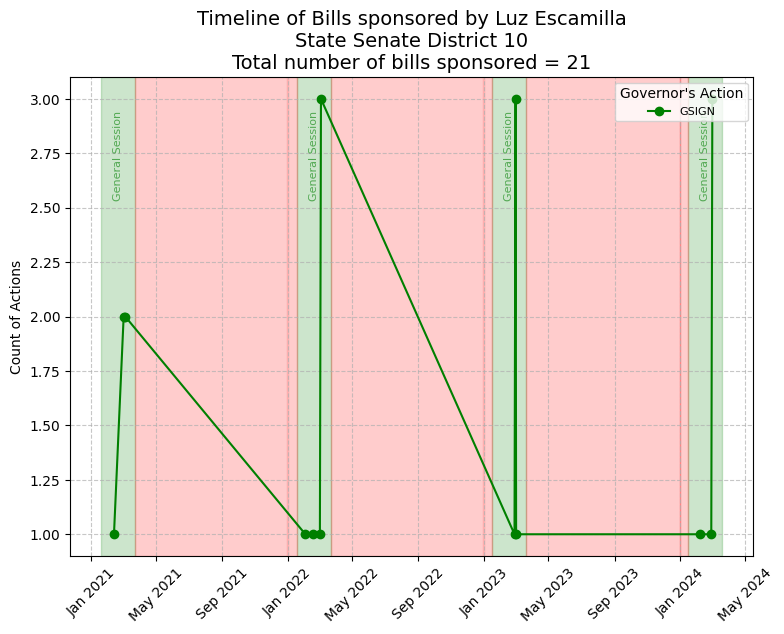

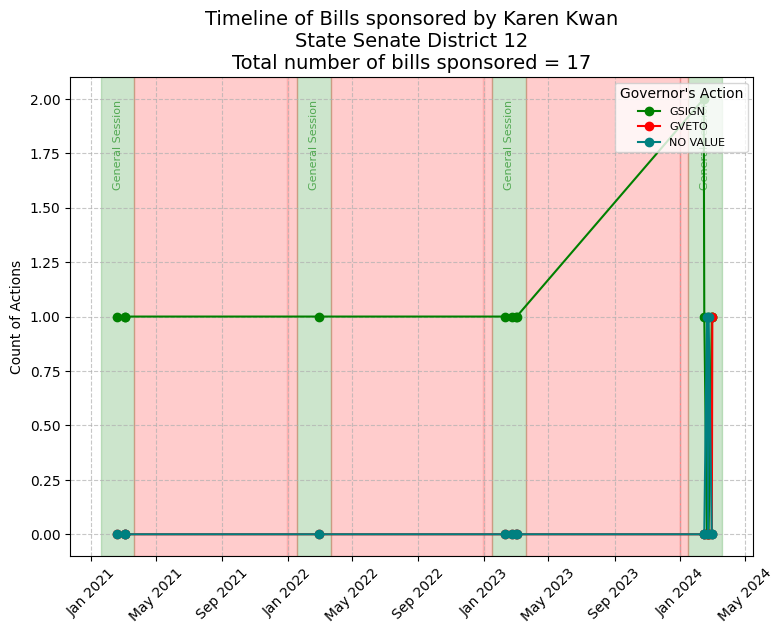

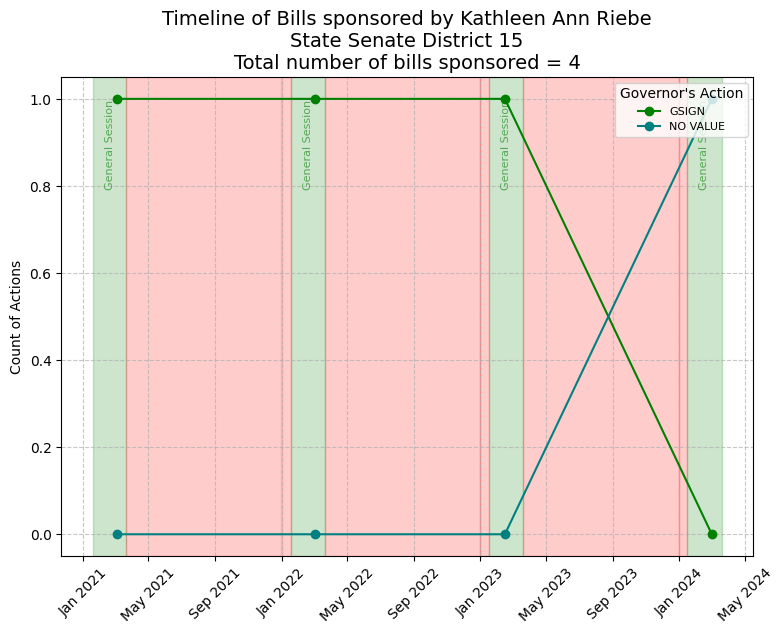

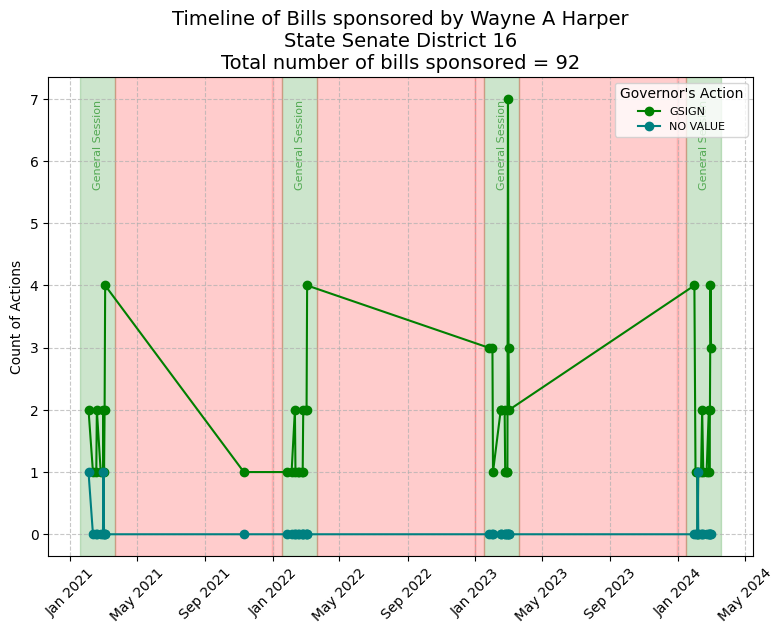

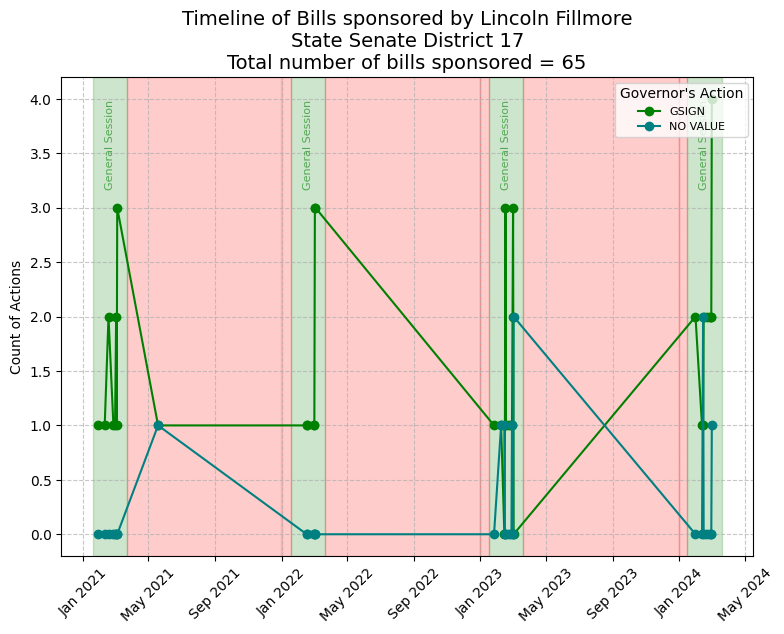

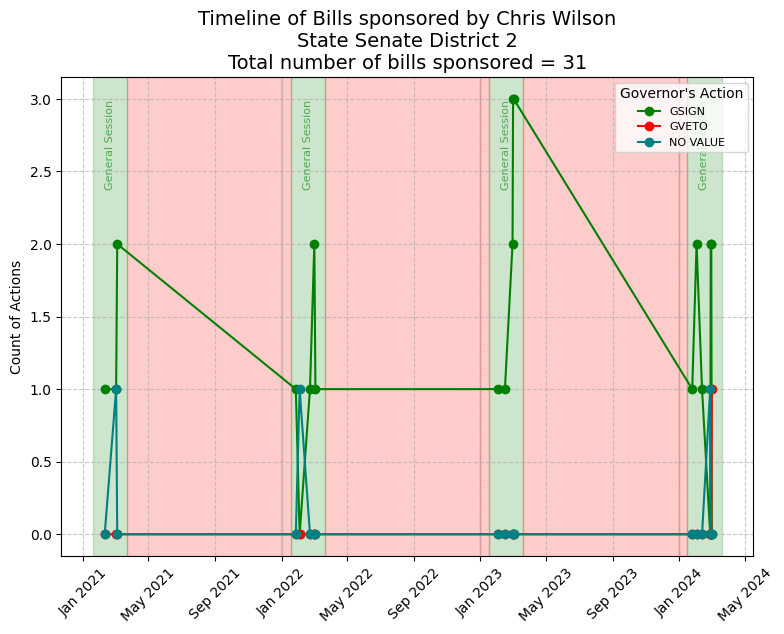

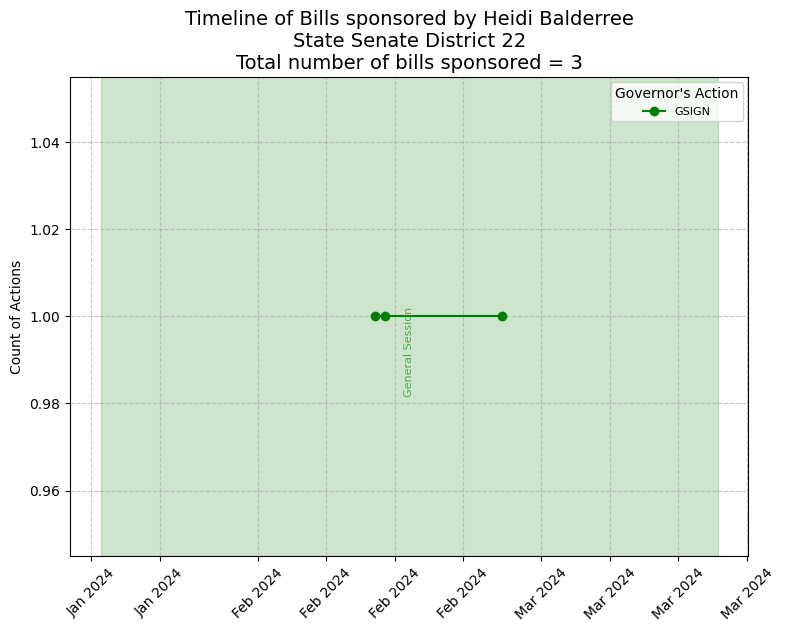

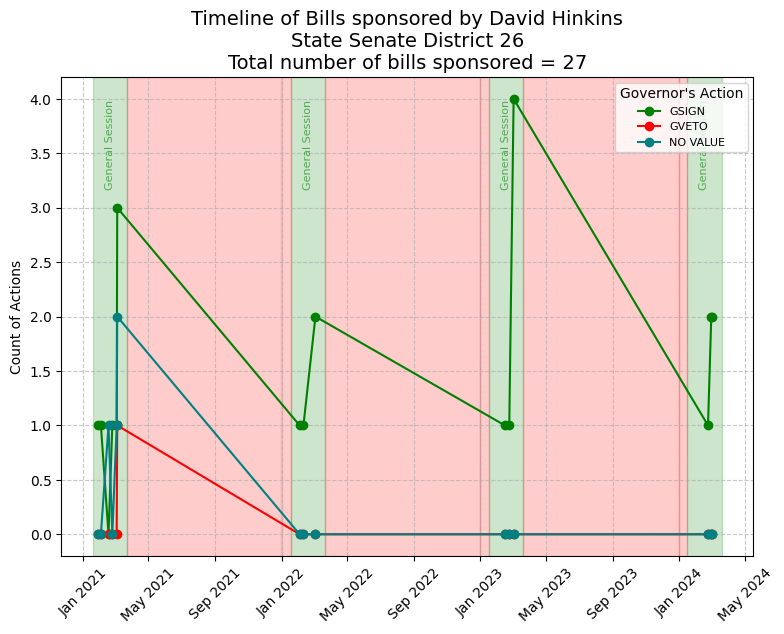

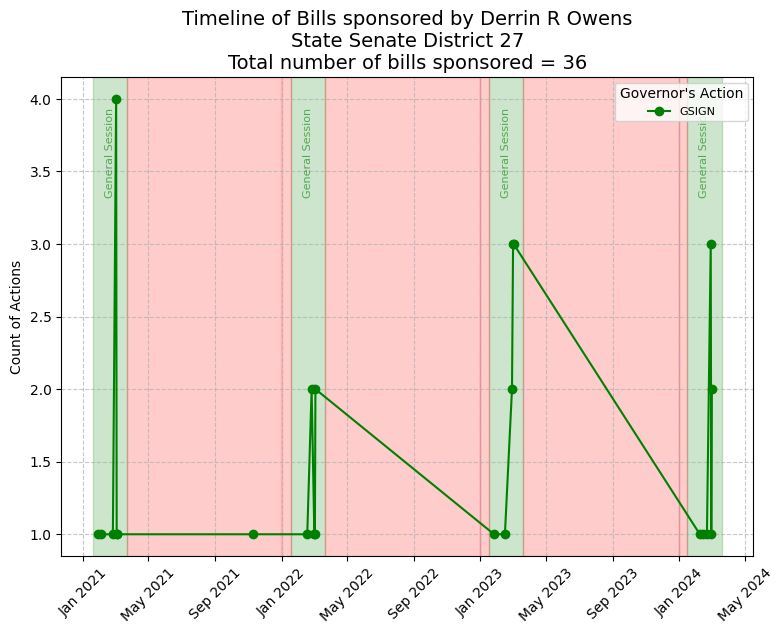

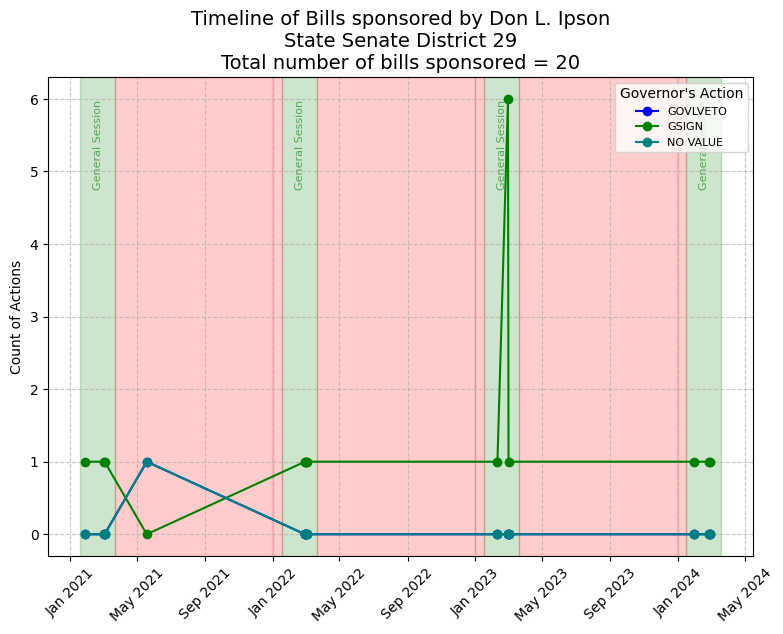

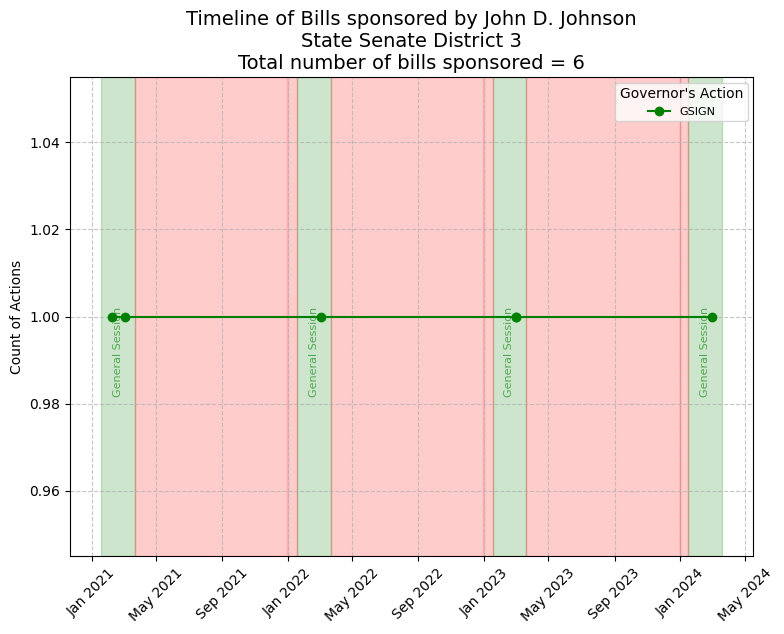

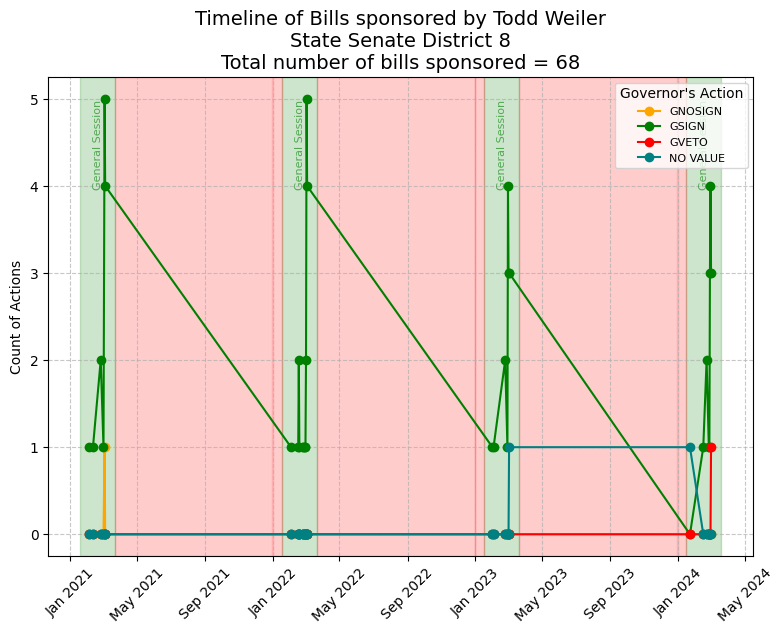

In [18]:
# Now we have the cahrts, lets save the data to a drive so we can use those charts to create a website

# bar chart and timline colors
color_map = {
    'GSIGN': 'green',
    'GVETO': 'red',
    'NO VALUE': 'teal',
    'GOVLVETO': 'blue',
    'GNOSIGN': 'orange',
    None: 'purple'  # Using None for NaN values
}
# category treemap colors
treemap_colormap = {
    'Healthcare': '#FFB11C',
    'Education': '#FF6100',
    'Agriculture & Food': '#85EA00',
    'Government & Administration': '#85EAA8',
    'Environment': '#165EA8',
    'Housing': '#165E65',
    'Technology & Innovation': '#601565',
    'Transportation': '#001565',
    'Economy & Business': '#0015FF',
    'Civil Rights & Justice': '#7DFF74',
    'Military & Defense': '#FFFF7F',
    'Energy': '#FF7AFF',
    'Other': '#402100'
}
# word cloud customization
wordcloud_colors = 'tab20c'
limit_cloud_words = 30
# folder to save charts to
base_drive_path = '/content/drive/My Drive/ut_pol/bill_charts'

# ########### #
# STATE HOUSE #
# ########### #
print('*****************************\nLooping through State House\n*****************************')
state_house = merged_df.loc[merged_df['Office'] == 'State House']

for candidate in state_house['Name on Ballot'].unique():
  # Bar Chart #
  bar_chart_gov_actions(df=state_house,
                      name_on_ballot=candidate,
                      color_map=color_map,
                      print_info=False,
                      save_chart=False,
                      show_chart=False)
  # Timeline #
  timeline_gov_actions(df=state_house,
                       name_on_ballot=candidate,
                       color_map=color_map,
                       print_info=False,
                       save_chart=False,
                       show_chart=False)
  # Treemap #
  treemap_bill_categories(df=state_house,
                        name_on_ballot=candidate,
                        color_map=treemap_colormap,
                        print_info=False,
                        save_chart=False,
                        show_chart=False)
  # Wordcloud #
  wordcloud_bill_titles(df=state_house,
                        name_on_ballot=candidate,
                        color_map=wordcloud_colors,
                        num_words=limit_cloud_words,
                        base_drive_path=base_drive_path,
                        show_chart=False,
                        print_info=False,
                        save_chart=False)

# ############ #
# STATE SENATE #
# ############ #

print('*****************************\nLooping through State Senate\n*****************************')
state_senate = merged_df.loc[merged_df['Office'] == 'State Senate']

for candidate in state_senate['Name on Ballot'].unique():
  # Bar Chart #
  bar_chart_gov_actions(df=state_senate,
                        name_on_ballot=candidate,
                        color_map=color_map,
                        print_info=False,
                        save_chart=False,
                        show_chart=False)
  # Timeline #
  timeline_gov_actions(df=state_senate,
                       name_on_ballot=candidate,
                       color_map=color_map,
                       print_info=False,
                       save_chart=False,
                       show_chart=True)
  # Treemap #
  treemap_bill_categories(df=state_senate,
                          name_on_ballot=candidate,
                          color_map=treemap_colormap,
                          print_info=False,
                          save_chart=False,
                          show_chart=False)
  # # Wordcloud #
  wordcloud_bill_titles(df=state_senate,
                      name_on_ballot=candidate,
                      color_map=wordcloud_colors,
                      num_words=limit_cloud_words,
                      base_drive_path=base_drive_path,
                      show_chart=False,
                      print_info=False,
                      save_chart=False)

In [19]:
from datetime import datetime, timedelta

def get_general_session_start_date(year):
    """
    Get the start date of the general session for a given year.
    The general session starts on the 1st Tuesday after the 3rd Monday in January.
    """
    jan_one = pd.Timestamp(year=year, month=1, day=1)
    third_monday = jan_one + pd.DateOffset(weeks=2, weekday=0)
    tuesday_after = third_monday + pd.DateOffset(days=1)
    return tuesday_after


In [51]:
def adjust_juneteenth(date):
  if date.weekday() in [5,6]: # saturday to sunday
    return date + timedelta(days=(7-date.weekday())) # move to the next monday
  elif date.weekday() in [1,2,3,4]: # tuesday to friday
    return date - timedelta(days=date.weekday()) # move to the earlier monday
  else:
    return date

In [52]:
def adjust_for_weekends(date):
  if date.weekday() == 5: # saturday
    return date - timedelta(days=1) # move to friday
  elif date.weekday() == 6: # sunday
    return date + timedelta(days=1) # move to monday
  else:
    return date

In [83]:
def get_nth_weekday(year, month, weekday, n):
    """Get the nth occurrence of a specific weekday in a given month and year."""
    # weekday: 0=Monday, 1=Tuesday, ..., 6=Sunday
    # first day of the month
    first_day = datetime(year, month, 1)
    days_to_add = (weekday - first_day.weekday() + 7) % 7
    first_occurance = first_day + timedelta(days=days_to_add)
    nth_occurrence = first_occurance + timedelta(weeks=(n-1))
    return pd.Timestamp(nth_occurrence)

In [84]:
from datetime import datetime, timedelta

def get_last_weekday(year, month, weekday):
    """
    Find the last occurrence of a specified weekday in a given month.

    Parameters:
    - year: The year as an integer.
    - month: The month as an integer.
    - weekday: The day of the week as an integer (0=Monday, 1=Tuesday, ..., 6=Sunday).

    Returns:
    - A datetime object representing the last occurrence of the specified weekday.
    """
    # Get the last day of the month
    if month == 12:
        last_day = datetime(year + 1, 1, 1) - timedelta(days=1)
    else:
        last_day = datetime(year, month + 1, 1) - timedelta(days=1)

    # Find the last occurrence of the specified weekday
    while last_day.weekday() != weekday:
        last_day -= timedelta(days=1)

    return pd.Timestamp(last_day)


In [55]:
mlk_day = get_nth_weekday(year=2024, month=1, weekday=0, n=3)

In [65]:
get_last_weekday(2024, month=5, weekday=0)

datetime.datetime(2024, 5, 27, 0, 0)

In [50]:
datetime.today() - timedelta(days=10)

datetime.datetime(2024, 10, 11, 4, 12, 43, 15291)

In [49]:
adjust_juneteenth(datetime.today() - timedelta(days=10))

datetime.datetime(2024, 10, 7, 4, 12, 34, 268815)

In [71]:
year = 2024
new_years_day = pd.Timestamp(year=year, month=1, day=1)
juneteenth = pd.Timestamp(year=year, month=6, day=19)
independence_day = pd.Timestamp(year=year, month=7, day=4)
pioneer_day = pd.Timestamp(year=year, month=7, day=24)
veterans_day = pd.Timestamp(year=year, month=11, day=11)
christmas = pd.Timestamp(year=year, month=12, day=25)

In [72]:
print('new years day', new_years_day)
print('juneteenth', juneteenth)
print('independence day', independence_day)
print('pioneer day', pioneer_day)
print('veterans day', veterans_day)
print('christmas', christmas)

new years day 2024-01-01 00:00:00
juneteenth 2024-06-19 00:00:00
independence day 2024-07-04 00:00:00
pioneer day 2024-07-24 00:00:00
veterans day 2024-11-11 00:00:00
christmas 2024-12-25 00:00:00


In [73]:
print('new years day', adjust_for_weekends(new_years_day))
print('independece day', adjust_for_weekends(independence_day))
print('pioneer day', adjust_for_weekends(pioneer_day))
print('veterans day', adjust_for_weekends(veterans_day))
print('christmas', adjust_for_weekends(christmas))
print('juneteenth', adjust_juneteenth(juneteenth))

new years day 2024-01-01 00:00:00
independece day 2024-07-04 00:00:00
pioneer day 2024-07-24 00:00:00
veterans day 2024-11-11 00:00:00
christmas 2024-12-25 00:00:00
juneteenth 2024-06-17 00:00:00


In [85]:
mlk_day = get_nth_weekday(year, month=1, weekday=0, n=3) # third monday of January
presidents_day = get_nth_weekday(year, month=2, weekday=0, n=3) # third monday of february
memorial_day = get_last_weekday(year, month=5, weekday=0) # last monday of May
labor_day = get_nth_weekday(year, month=9, weekday=0, n=1) # first monday of september
columbus_day = get_nth_weekday(year, month=10, weekday=0, n=2) # second monday of October
thanksgiving_day = get_nth_weekday(year, month=11, weekday=3, n=4) # fourth thursday of november


In [86]:
print('mlk', mlk_day)
print('presidents', presidents_day) # wrong
print('memorial', memorial_day)
print('labor', labor_day) # wrong
print('columbus', columbus_day) # wrong
print('thanksgiving', thanksgiving_day) # wrong

mlk 2024-01-15 00:00:00
presidents 2024-02-19 00:00:00
memorial 2024-05-27 00:00:00
labor 2024-09-02 00:00:00
columbus 2024-10-14 00:00:00
thanksgiving 2024-11-28 00:00:00


In [80]:
# Make a list of holidays to determine end date of general legislative session

""" Utah State Holidays
Jan 1 aka New Years Day
Third Monday of January aka Dr. Martin Luther King, Jr Day
Third Monday of February aka Washington & Lincoln Day
Last Monday of May aka Memorial Day
June 19 aka Juneteenth National Freedom Day
July 4 aka Independency Day
July 24 aka Pioneer Day
First Monday of September aka Labor Day
Second Monday of October aka Columbus Day
November 11 aka Veterans Day
Fourth Thursday of November aka Thanksgiving Day
December 25 aka Christmas Day

If holiday falls on a SUnday the next Monday will the the holiday
If holiday fall on a Saturday Friday will be the holiday
If June 19 falls on a Tuesday, Wednesday, Thursday or Friday holiday is on next Monday
If June 19 is on a Saturday or Sunday holiday is on the next Monday
"""

def get_utah_state_holidays(year):
  holidays = []

  # fixed dates
  new_years_day = pd.Timestamp(year=year, month=1, day=1)
  juneteenth = pd.Timestamp(year=year, month=6, day=19)
  independence_day = pd.Timestamp(year=year, month=7, day=4)
  pioneer_day = pd.Timestamp(year=year, month=7, day=24)
  veterans_day = pd.Timestamp(year=year, month=11, day=11)
  christmas = pd.Timestamp(year=year, month=12, day=25)

  # adjust for weekends
  holidays.append(adjust_for_weekends(new_years_day))
  holidays.append(adjust_for_weekends(independence_day))
  holidays.append(adjust_for_weekends(pioneer_day))
  holidays.append(adjust_for_weekends(veterans_day))
  holidays.append(adjust_for_weekends(christmas))
  holidays.append(adjust_juneteenth(juneteenth))

  # days that change
  mlk_day = get_nth_weekday(year, month=1, weekday=0, n=3) # third monday of January
  presidents_day = get_nth_weekday(year, month=2, weekday=0, n=3) # third monday of february
  memorial_day = get_last_weekday(year, month=5, weekday=0) # last monday of May
  labor_day = get_nth_weekday(year, month=9, weekday=0, n=1) # first monday of september
  columbus_day = get_nth_weekday(year, month=10, weekday=0, n=2) # second monday of October
  thanksgiving_day = get_nth_weekday(year, month=11, weekday=3, n=4) # fourth thursday of november

  holidays.extend([mlk_day, presidents_day, memorial_day, labor_day, columbus_day, thanksgiving_day])

  return sorted(holidays)

In [81]:
get_utah_state_holidays(2024)

[Timestamp('2024-01-01 00:00:00'),
 Timestamp('2024-01-15 00:00:00'),
 Timestamp('2024-02-16 00:00:00'),
 Timestamp('2024-05-27 00:00:00'),
 Timestamp('2024-06-17 00:00:00'),
 Timestamp('2024-07-04 00:00:00'),
 Timestamp('2024-07-24 00:00:00'),
 Timestamp('2024-09-03 00:00:00'),
 Timestamp('2024-10-13 00:00:00'),
 Timestamp('2024-11-11 00:00:00'),
 Timestamp('2024-11-24 00:00:00'),
 Timestamp('2024-12-25 00:00:00')]

In [38]:
# the general session goes for 45 weekdays minus federal holidays

def get_general_session_end_date(year):
    """
    Get the end date of the general session for a given year.
    The general session ends 45 weekdays after the start minus
    federal holidays.
    """

    start_date = get_general_session_start_date(year)
    holidays = calendar().holidays(start=start_date, end=pd.Timestamp(year=year, month=12, day=31))



In [ ]:
    def is_general_session(date):
        year = date.year
        start_date = get_general_session_start_date(year)
        holidays = []  # Define your holidays here
        general_session_days = pd.bdate_range(start_date, periods=45, holidays=holidays)
        return date in general_session_days

In [48]:
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar

# Set the start date
start_date = pd.Timestamp('2024-10-18')

# Create a calendar of US federal holidays
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=start_date, end=start_date + pd.Timedelta(days=60))
print(holidays)
# # Generate a business day range excluding holidays
# business_days = pd.bdate_range(start=start_date, periods=45, holidays=holidays)

# print(business_days)

DatetimeIndex(['2024-11-11', '2024-11-28'], dtype='datetime64[ns]', freq=None)


In [ ]:
""" Utah State Holidays
Jan 1
Third Monday of January aka Dr. Martin Luther King, Jr Day
Third Monday of February aka Washington & Lincoln Day
Last Monday of May aka Memorial Day
June 19 aka Juneteenth National Freedom Day
July 4 aka Independency Day
July 24 aka Pioneer Day
First Monday of September aka Labor Day
Second Monday of October aka Columbus Day
November 11 aka Veterans Day
Fourth Thursday of November aka Thanksgiving Day
December 25 aka Christmas Day

If holiday falls on a SUnday the next Monday will the the holiday
If holiday fall on a Saturday Friday will be the holiday
If June 19 falls on a Tuesday, Wednesday, Thursday or Friday holiday is on next Monday
If June 19 is on a Saturday or Sunday holiday is on the next Monday
"""

In [34]:
year = 2022
jan_one = pd.Timestamp(year=year, month=1, day=1)
print(jan_one.strftime('%Y-%m-%d'))
third_monday = jan_one + pd.DateOffset(weeks=2, weekday=0)
tuesday_after = third_monday + pd.DateOffset(days=1)
print(tuesday_after.strftime('%Y-%m-%d'))

2022-01-01
2022-01-18


In [29]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

def stacked_bar_gov_actions(df, name_on_ballot, color_map, show_chart=False, print_info=False, save_chart=False):
    import matplotlib.pyplot as plt
    import pandas as pd

    # Filter candidate-specific data
    candidate_bills = df[df['Name on Ballot'] == name_on_ballot]
    candidate_name = " ".join([x.capitalize() for x in name_on_ballot.split()])
    display_district = candidate_bills['Display District'].iloc[0] if not candidate_bills.empty else "N/A"
    office = candidate_bills['Office'].iloc[0] if not candidate_bills.empty else "N/A"

    # Convert 'Date Passed' to datetime and extract year
    candidate_bills['Date Passed'] = pd.to_datetime(candidate_bills['Date Passed'])
    candidate_bills['Year'] = candidate_bills['Date Passed'].dt.year

    print(candidate_bills.info())

    # Define US federal holidays
    holidays = calendar().holidays(start=candidate_bills['Date Passed'].min(), end=candidate_bills['Date Passed'].max())


    # Define a helper function to determine if a date is in the general session
    def is_general_session(date):
        year = date.year
        start_date = get_general_session_start_date(year)
        business_days = pd.bdate_range(start_date, periods=60)
        general_session_days = [day for day in business_days if day not in holidays][:45]
        return date in general_session_days

    # Add column to categorize general vs. special session
    candidate_bills['Session Type'] = candidate_bills['Date Passed'].apply(
        lambda x: 'General Session' if is_general_session(x) else 'Special Session')

    print(candidate_bills.head())
    print(candidate_bills.info())

    # Group by year and session type, and then get counts of governor's actions
    grouped_data = candidate_bills.groupby(['Year', 'Session Type', 'Governor\'s Action']).size().unstack(fill_value=0)

    print(grouped_data)
    # Prepare the chart
    fig, ax = plt.subplots(figsize=(10, 6))

    # Loop over each year to create bars for general and special sessions
    for year in sorted(candidate_bills['Year'].unique()):
        bottom_general = 0
        bottom_special = 0
        for action in grouped_data.columns:
            count_general = grouped_data.get((year, 'General Session'), {}).get(action, 0)
            count_special = grouped_data.get((year, 'Special Session'), {}).get(action, 0)

            # Plot the general session counts for the year
            ax.bar(year - 0.2, count_general, bottom=bottom_general, width=0.4,
                   label=action if year == sorted(candidate_bills['Year'].unique())[0] else "",
                   color=color_map.get(action, 'black'), alpha=0.7)
            bottom_general += count_general

            # Plot the special session counts for the year
            ax.bar(year + 0.2, count_special, bottom=bottom_special, width=0.4,
                   color=color_map.get(action, 'black'), alpha=0.7)
            bottom_special += count_special

    # Formatting the chart
    ax.set_title(f"Bills Sponsored by {candidate_name}\n General vs. Special Sessions", fontsize=14)
    ax.set_xlabel('Year')
    ax.set_ylabel('Count of Bills')
    ax.legend(title='Governor\'s Action', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_xticks(sorted(candidate_bills['Year'].unique()))
    ax.set_xticklabels([str(year) for year in sorted(candidate_bills['Year'].unique())])

    plt.tight_layout()

    if print_info:
        print(f"Stacked bar chart for {candidate_name} in {display_district} created.")

    # Save or show the chart based on parameters
    if save_chart:
        save_candidate_chart(fig, office, candidate_name, "stacked_bar", base_drive_path)

    if show_chart:
        plt.show()
    else:
        plt.close(fig)


In [45]:
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

def get_general_session_start_date(year):
    # Calculate the first Tuesday after the third Monday in January
    # This is your implementation to find the start date
    start_date = pd.Timestamp(year=year, month=1, day=1)
    start_date += pd.DateOffset(weeks=3)  # Move to the fourth week
    start_date += pd.DateOffset(days=1)    # Move to Tuesday
    return start_date

def is_general_session(date):
    year = date.year
    start_date = get_general_session_start_date(year)

    # Calculate 45 weekdays (excluding holidays) from the start date
    holidays = []  # Define your holidays here
    general_session_days = pd.bdate_range(start_date, periods=45, holidays=holidays)

    # Check if the date is within the general session days
    return date in general_session_days


In [46]:
def stacked_bar_gov_actions(df, name_on_ballot, color_map, show_chart=False):
    import matplotlib.pyplot as plt
    import pandas as pd

    # Get the candidate bills
    candidate_bills = df[df['Name on Ballot'] == name_on_ballot]
    candidate_bills['Date Passed'] = pd.to_datetime(candidate_bills['Date Passed'])

    # Prepare the data
    candidate_bills['Year'] = candidate_bills['Date Passed'].dt.year
    candidate_bills['Is General Session'] = candidate_bills['Date Passed'].apply(lambda x: is_general_session(x))

    # Group by year, session type, and governor's action
    grouped_data = candidate_bills.groupby(['Year', 'Is General Session', 'Governor\'s Action']).size().unstack(fill_value=0)

    # Create a DataFrame for the stacked bar chart
    # Separate general and special session counts
    if not grouped_data.empty:
        general_session_data = grouped_data.loc[(slice(None), True), :].fillna(0)
        special_session_data = grouped_data.loc[(slice(None), False), :].fillna(0)

        # Rename columns for clarity
        general_session_data.columns = [f'General Session - {col}' for col in general_session_data.columns]
        special_session_data.columns = [f'Special Session - {col}' for col in special_session_data.columns]

        # Combine general and special session data
        combined_data = pd.concat([general_session_data, special_session_data], axis=1, sort=False).fillna(0)

        # Plotting
        ax = combined_data.plot(kind='bar', stacked=True, color=[color_map.get(action.split(' - ')[-1], 'black') for action in combined_data.columns])

        plt.title(f"Stacked Bar Chart of Bills Sponsored by {name_on_ballot}")
        plt.xlabel("Year")
        plt.ylabel("Count of Bills")
        plt.legend(title='Governor\'s Action', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.xticks(rotation=45)

        plt.tight_layout()
        if show_chart:
            plt.show()
        else:
            plt.close()
    else:
        print("No data available for the selected candidate.")


In [47]:
candidate_name = 'TODD WEILER'
stacked_bar_gov_actions(df=merged_df,
                        name_on_ballot=candidate_name,
                        color_map=color_map,
                        show_chart=True)


KeyError: False